In [1]:
#%load_ext snakeviz

# Set seeds for repeatability.
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(2)


# Import data processing modules.
import pandas as pd
import numpy as np

# Import machine learning modules.
import tensorflow as tf
from tensorflow import keras

import keras

from keras import layers
from keras import optimizers
from keras import regularizers
from keras import initializers

import sklearn

import wandb
from wandb.keras import WandbCallback

# Import Omphalos modules.
import generate_inputs as gi
import file_methods as fm
import my_metrics as mm
import omphalos_plotter as op
import attributes as attr
import labels as lbls

# Import data visualisation modules.
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import sklearn.preprocessing as skp

print(tf.__version__)
print(keras.__version__)
print(sklearn.__version__)

2.3.1
2.4.3
0.23.2


### Import and extract data

In [2]:
train_set = fm.unpickle('pure_train.pickle')
test_set = fm.unpickle('pure_test.pickle')

In [3]:
attributes_df = attr.initial_conditions(train_set, primary_species=True, mineral_vols=True)
attributes_df.drop(columns=['X', 'Y', 'Z', 'C5H7O2NSO4'], inplace=True)
labels_df = lbls.secondary_precip(train_set)

/usr/local/lib/python3.8/site-packages/pandas/core/frame.py:6390: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


In [14]:
# Nifty oneliner to check if a species has been randomised.
attributes_df.describe().loc['std'] >= 1e-15

CO2(aq)           True
O2(aq)           False
NH3(aq)          False
Mg++             False
Al+++            False
Fe++             False
Fe+++            False
Ca++              True
Ca44++            True
K+               False
SO4--             True
S34O4--           True
B(OH)3(aq)       False
HPO4--           False
H2S(aq)          False
H2S34(aq)        False
SiO2(aq)         False
Na+              False
Methane(aq)      False
Cl-              False
NO3-             False
Formaldehyde      True
FeS(am)          False
FeS34(am)        False
SiO2(am)         False
Quartz           False
Siderite         False
Calcite           True
Calcite44         True
K-Feldspar       False
Kaolinite        False
C5H7O2NSO4(s)    False
Name: std, dtype: bool

### Define Keras model

In [16]:
def create_model():

    # Hyperparameters.

    wandb.init(project='1086-dev')

    wandb.config.dropout = 1e-5
    wandb.config.learning_rate = 0.0002
    wandb.config.epochs = 2500
    wandb.config.batch_size = 95
    wandb.config.l2_reg = 0
    wandb.config.seed = 10
    wandb.config.nodes = 256
    wandb.config.seed = 10
    wandb.config.elu_alpha = 0.009
    wandb.config.bn_epsilon = 1e-10
    
    model = tf.keras.models.Sequential([
        layers.Input(shape=(5,)),
        layers.BatchNormalization(epsilon=wandb.config.bn_epsilon),
        layers.Dense(wandb.config.nodes, activation=layers.ELU(alpha=wandb.config.elu_alpha), kernel_initializer = initializers.GlorotUniform(seed=wandb.config.seed), name='Input'),
        layers.Dense(wandb.config.nodes, activation=layers.ELU(alpha=wandb.config.elu_alpha), kernel_initializer = initializers.GlorotUniform(seed=wandb.config.seed), name='Pattern'),
        layers.Dense(wandb.config.nodes, activation=layers.ELU(alpha=wandb.config.elu_alpha), kernel_initializer = initializers.GlorotUniform(seed=wandb.config.seed), name='Pattern2'),
        layers.Dense(wandb.config.nodes, activation=layers.ELU(alpha=wandb.config.elu_alpha), kernel_initializer = initializers.GlorotUniform(seed=wandb.config.seed), name='Pattern3'),
        layers.Dense(wandb.config.nodes, activation=layers.ELU(alpha=wandb.config.elu_alpha), kernel_initializer = initializers.GlorotUniform(seed=wandb.config.seed), name='Summation'),
        layers.Dense(1, kernel_initializer=tf.keras.initializers.constant(0), name='Output')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=wandb.config.learning_rate),
          loss=tf.keras.losses.MeanSquaredError(reduction="auto"),
             metrics=([tf.keras.losses.MeanAbsoluteError(reduction="auto"), tf.keras.losses.MeanAbsolutePercentageError(reduction="auto")]))

    return model

### Build SciKitLearn Pipeline

In [24]:
x = attributes_df.loc[:, ['CO2(aq)', 'Ca++', 'Calcite', 'SO4--', 'Formaldehyde']].xs(1, level=1)
y = (labels_df.xs(5, level=1)['Calcite'] + labels_df.xs(5, level=1)['Calcite44']).drop(columns=['File Num'])

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, Normalizer, QuantileTransformer

scaler = QuantileTransformer(output_distribution='normal')
power_scaler = PowerTransformer()

numeric_transformer = Pipeline(steps=[('scaler', scaler)])
#label_transformer = Pipeline(steps=[('scaler', power_scaler)])
#numeric_transformer = Pipeline(steps=[('scaler', scaler), ('normalizer', Normalizer())])

In [19]:
numeric_features = x.select_dtypes(include=['int64', 'float64']).columns
numeric_labels = y

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

In [20]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import PowerTransformer, Normalizer, quantile_transform

from keras.wrappers.scikit_learn import KerasRegressor

regressor = KerasRegressor(build_fn=create_model, verbose=0)

#TTregressor = TransformedTargetRegressor(regressor=regressor, transformer=PowerTransformer())

rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', rregressor)])

NameError: name 'rregressor' is not defined

In [172]:
rf.fit(x_train, y_train, TTregressor__batch_size=wandb.config.batch_size, TTregressor__epochs=wandb.config.epochs, TTregressor__validation_data=(x_test, y_test),
       TTregressor__shuffle=False, TTregressor__callbacks=[WandbCallback()], TTregressor__verbose=0)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,2499
loss,0.09245
mean_absolute_error,0.22212
mean_absolute_percentage_error,163.77264
val_loss,0.40479
val_mean_absolute_error,0.49656
val_mean_absolute_percentage_error,912942.8125
_step,2499
_runtime,1305
_timestamp,1602165717
best_val_loss,0.00015


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,████▇▇▆▆▅▅▅▄▄▄▃▃▄▃▂▃▃▂▂▃▂▃▂▂▂▂▂▂▁▁▂▃▁▁▂▁
mean_absolute_error,████▇▇▇▆▆▆▅▅▅▄▄▄▅▃▃▃▃▂▃▃▃▄▂▂▂▂▂▃▁▁▂▄▁▁▃▂
mean_absolute_percentage_error,█████▇▇▆▆▅▅▅▅▄▄▄▅▃▃▄▄▂▃▄▃▄▂▂▃▂▂▂▁▁▂▅▁▁▃▂
val_loss,▂▃▂▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▃▅▅▄▄▄▄▄▃▅▅▄▄█▇▆▆
val_mean_absolute_error,▅▅▄▁▃▃▃▃▃▄▃▄▄▄▄▄▄▄▅▅▅▄▆▅▇▇▆▆▆▆▆▅▆▆▆▆██▇▇
val_mean_absolute_percentage_error,▅▆▄▁▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▄▅▅▅▆▆▆▆▆▆▆▆▇▆▆▆█▇▇▇
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: wandb version 0.10.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   QuantileTransformer(output_distribution='normal'))]),
                                                  Index(['CO2(aq)', 'Ca++', 'Ca44++', 'Calcite', 'Calcite44'], dtype='object'))])),
                ('TTregressor',
                 TransformedTargetRegressor(regressor=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x1542a03d0>,
                                            transformer=PowerTransformer()))])

## Benchmark

In [125]:
from sklearn.preprocessing import power_transform

v = rf[:1].fit_transform(x_train)
w = np.array(y_train)
u = power_transform(w.reshape(-1,1))

In [103]:
y_mean = u.mean()
print(y_mean)

-2.84644060394632e-17


In [104]:
mean_array = np.ones(u.shape) * y_mean
tf.losses.MeanAbsoluteError()(mean_array, u)
#tf.losses.MeanSquaredError()(mean_array, y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=0.7724879384040833>

In [93]:
tf.keras.losses.MeanSquaredError(reduction="auto")(model(x_train), y_train)
#tf.keras.losses.MeanAbsoluteError(reduction="auto")(model(x_train[:2]), y_train[0:2])

<tf.Tensor: shape=(), dtype=float64, numpy=0.9978706240653992>

## Pre-net visualisation

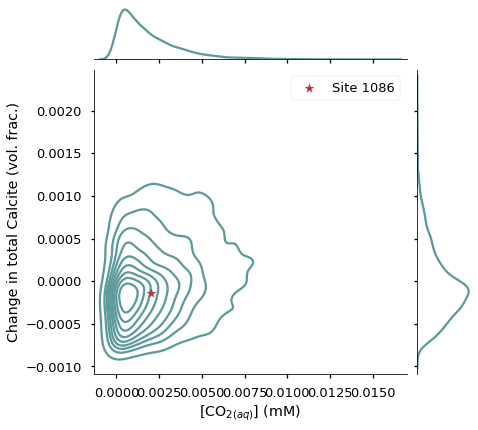

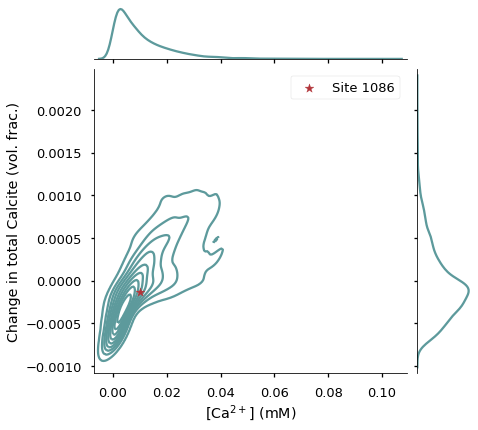

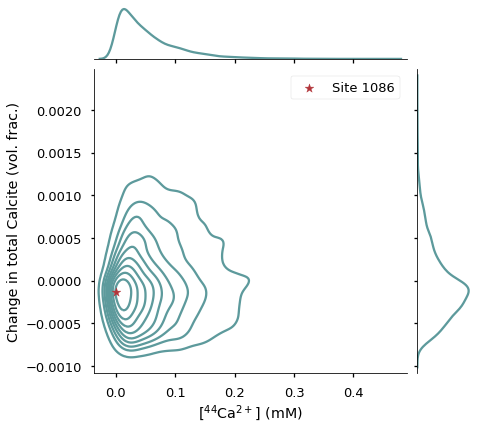

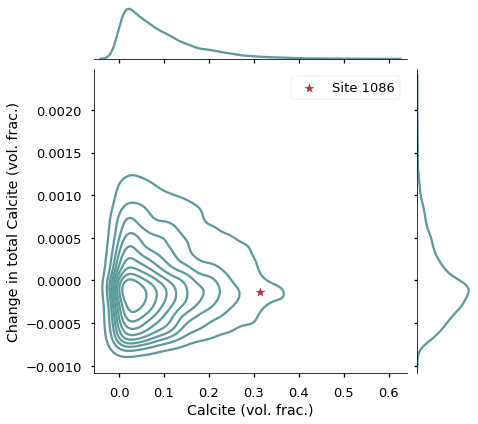

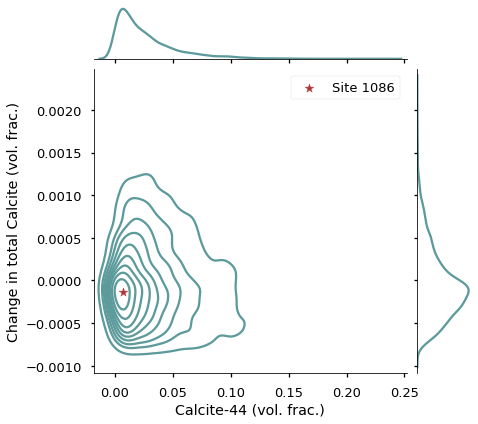

In [25]:
plt.style.use('seaborn-talk')
for i, x_label, x_data, sample_bound, crunch_point in zip((1, 2, 3, 4, 5), ['[CO$_{2(aq)}$] (mM)', '[Ca$^{2+}$] (mM)', '[$^{44}$Ca$^{2+}$] (mM)', 'Calcite (vol. frac.)', 'Calcite-44 (vol. frac.)'],
    [x_train['CO2(aq)'], x_train['Ca++'], x_train['Formaldehyde'], x_train['Calcite'], x_train['SO4--']],
    [[0.0009, 0.0029], [0,0], [0.00012, 0.00032], [0.08, 0.10], [0.0009, 0.0029]],
    [2.00e-3, 1.02e-2, 2.16e-4, 0.313, 0.00664]):
    g = sns.jointplot(x=x_data, y=y_train, kind="kde", color=[0.3663776351765568, 0.6057935659905949, 0.6135760192192385])
    g.ax_joint.set_xlabel(x_label)
    g.ax_joint.set_ylabel('Change in total Calcite (vol. frac.)')
    x_mean = x_data.mean()
    g.ax_joint.scatter(crunch_point, -0.0001374514, marker='*', color='#b2353a', label='Site 1086', zorder=2)
    g.ax_joint.legend()
    #g.ax_joint.plot(np.ones(100) * x_mean, np.linspace(-0.0010, 0.0015, 100), '--', color='#536267')
    #g.ax_joint.plot(np.ones(100) * sample_bound[0], np.linspace(-0.0010, 0.0015, 100), '-', color='#536267')
    #g.ax_joint.plot(np.ones(100) * sample_bound[1], np.linspace(-0.0010, 0.0015, 100), '-', color='#536267')
    g.savefig('fig{}'.format(i))



In [153]:
x_test.mean()

CO2(aq)      0.001906
Ca++         0.010361
Ca44++       0.000220
Calcite      0.091585
Calcite44    0.001942
dtype: float64

In [35]:
cmap = sns.cubehelix_palette(start=1.30, rot=-0.70, gamma=5.00, hue=0.80, light=1.00, dark=0.70, as_cmap=True)
print(sns.cubehelix_palette(start=1.30, rot=-0.70, gamma=5.00, hue=0.80, light=1.00, dark=0.70))

[[1.0, 1.0, 1.0], [0.600666033323316, 0.8042387476772097, 0.7618851871635605], [0.3663776351765568, 0.6057935659905949, 0.6135760192192385], [0.23273081525722783, 0.4177847625399162, 0.4867441037355283], [0.16663812218382065, 0.27703768000459084, 0.3765443372143581], [0.12662665095048134, 0.17327858963180406, 0.2746800220374649]]


# model.layers[0].output

In [195]:
rf.score(x_test, y_test)

0.12280212875904473

In [212]:
with rf[-1].regressor_.model as model:
    with tf.GradientTape() as tape:
        y_pred = model(x_train)
        loss = model.loss(y_train, y_pred)
tape.gradient(loss, model.get_weights())

AttributeError: __enter__